In [1]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path().absolute().parent))

In [2]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

from settings import PATH, SETTINGS
from utils import load_data_from_hdf5
from data_convert import process_data_approach_2
from catboost_approach import MyCB, TARGET_FEATURE

In [3]:
# edge shoud be 50-60

In [4]:
files = PATH['data']['amp_2']['generated']
df = pd.read_csv(PATH['data']['amp_2']['generated'] / SETTINGS['labels_file_name']).set_index('id')

In [5]:
dbs = []
for folder in PATH['data']['origin']['generated'].glob('*'):
    name = folder.stem
    db = pd.read_csv(folder / 'db.csv')
    db = db[['id', 'snr']]
    db['id_0'] = db['id'].apply(lambda x: f"{name}_{x:n}_0")
    db['id_1'] = db['id'].apply(lambda x: f"{name}_{x:n}_1")
    db = pd.concat([db[['id_0', 'snr']].rename(columns={'id_0': 'id'}),
                    db[['id_1', 'snr']].rename(columns={'id_1': 'id'})])
    db = db.set_index('id').sort_index()
    dbs.append(db)
db = pd.concat(dbs)

In [6]:
%%time
kwargs = {'tqdm': tqdm, 'random_state': SETTINGS['random_seed'], 'verbose': 0}
model = MyCB(**kwargs)
df = model.read_data()

Wall time: 31.2 ms


In [7]:
db0 = db.copy()
def fun(edge, db=db0, df=model.my_df):
    if isinstance(edge, list):
        edge = edge[0]
    model = MyCB(**kwargs)
    df = df.drop(columns=TARGET_FEATURE)
    df[TARGET_FEATURE] = (db['snr'] > edge).astype(int)
    model.my_df = df
    model.prepare_data()
    model.fit(*model.my_train)
    return model.score(*model.my_test)

In [8]:
%%time
edges = np.linspace(0, db0['snr'].max() * 0.8, 10)
res = [fun(edge) for edge in tqdm(edges)]

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 2min 41s


In [9]:
e = []
r = []
# with only one feature
e.append(np.array([ 0.        ,   6.15990699,  12.31981397,  18.47972096,
                   24.63962795,  30.79953494,  36.95944192,  43.11934891,
                   49.2792559 ,  55.43916288,  61.59906987,  67.75897686,
                   73.91888385,  80.07879083,  86.23869782,  92.39860481,
                   98.55851179, 104.71841878, 110.87832577, 117.03823276]))
r.append([0.6769462258853607, 0.6938641429552588, 0.7123130743907469, 0.7332771713275474, 0.758174947672282,
        0.7997375973261356, 0.8244053104456639, 0.8716894569100863, 0.9071866280188587, 0.9339344073042702,
        0.9600171705305128, 0.9734072685720205, 0.9805307812357544, 0.984447855588745, 0.9888191786607228,
        0.9880868851696694, 0.9881918942247332, 0.9891820813781091, 0.9918278548291044, 0.991546201476542])

# with full set of futures
e.append(np.array([0.        ,   6.28376879,  12.56753759,  18.85130638,
                   25.13507517,  31.41884396,  37.70261276,  43.98638155,
                   50.27015034,  56.55391914,  62.83768793,  69.12145672,
                   75.40522551,  81.68899431,  87.9727631 ,  94.25653189,
                  100.54030068, 106.82406948, 113.10783827, 119.39160706]))
r.append([0.823590404347882, 0.8556388976582423, 0.8882315386878494, 0.9219325064319327, 0.949964938860454,
        0.9701267178271593, 0.9840448798018977, 0.9878501134422476, 0.9911884195283364, 0.9923964933157174,
        0.9947843387676969, 0.9946713882133669, 0.9960698227982016, 0.9961289935666776, 0.9959297216709616,
        0.9950566016017567, 0.9963800477925151, 0.9951708474911766, 0.9955233686507738, 0.9971759952727123])

# with futures with one preparation fun
e.append(np.array([0.        ,  13.26573412,  26.53146824,  39.79720235,
                   53.06293647,  66.32867059,  79.59440471,  92.86013883,
                   106.12587294, 119.39160706]))
r.append([0.8254903526916892, 0.8979414635066525, 0.9606011968960215, 0.9853261209215273, 0.9917866490532952,
        0.9962049381194209, 0.9961317010668543, 0.9960680126110817, 0.9965613849610149, 0.9972180805013123])

# with 6 feature funs
e.append(np.array([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706]))
r.append([0.8280764217255173, 0.8992614704033508, 0.9590524874750093, 0.9850947406016919, 0.9919238466455116,
 0.9965789088041872, 0.9964487830535177, 0.9961331689797178, 0.9961943306462271, 0.9965258214349516])
         
# with 3 feature funs
e.append(np.array([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706]))
r.append([0.8211811138174235, 0.8870388905963102, 0.9466611489382197, 0.9672830783195512, 0.9765150434718627,
 0.9861069105673577, 0.9893544534924807, 0.9913383583520492, 0.9909716532311351, 0.9928867374843684])
         
# 1 with 2 feature funs
e.append([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706])
r.append([0.6845118268989381, 0.722719751400333, 0.7703482868165009, 0.7966778040132404, 0.8108186062785037,
 0.8206729001484621, 0.8367696882587681, 0.8285658651103602, 0.8556297079423814, 0.8323775405735958])
         
# 2 with 2 feature funs
e.append([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706])
r.append([0.6708768035025976, 0.7047210562639967, 0.7690384250510992, 0.8438170063896218, 0.9235323849057454,
 0.9666735058458259, 0.9782177338180804, 0.9859253932984681, 0.9827932139553325, 0.9840350973628881])

# 3 with 2 feature funs
e.append([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706])
r.append([0.6764306240228599, 0.7098225144561576, 0.7762942146743637, 0.8513295386760453, 0.9314275936777592,
 0.9696234990919659, 0.9790405767690946, 0.9862134442853212, 0.9840045592705167, 0.9876703163434979])

In [10]:
edges

array([  0.        ,  13.26573412,  26.53146824,  39.79720235,
        53.06293647,  66.32867059,  79.59440471,  92.86013883,
       106.12587294, 119.39160706])

In [11]:
res

[0.6764306240228599,
 0.7098225144561576,
 0.7762942146743637,
 0.8513295386760453,
 0.9314275936777592,
 0.9696234990919659,
 0.9790405767690946,
 0.9862134442853212,
 0.9840045592705167,
 0.9876703163434979]

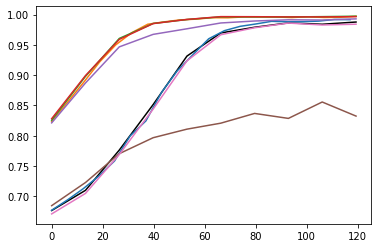

In [12]:
_, ax = plt.subplots()
ax.plot(edges, res, c='k')
for ie, ir in zip(e, r):
    ax.plot(ie, ir)